In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords

In [2]:
articles = pd.read_excel('/Users/clairefenton/Downloads/ATL_predictions_1941.xlsx')
articles_to_clean = pd.read_csv('/Users/clairefenton/Downloads/ATL_1941.csv')

In [3]:
articles['original_text'] = articles['original_text'].apply(lambda x : x[0:x.index('Â\xa0')])
articles['original_text'].str.strip()

0                                  "HONEYMOON PREFERRED"
1                 POLICEMEN KEPT BUSY AS 1940 PASSES OUT
2                                  "HONEYMOON PREFERRED"
3      SLAYER FREED WITHOUT BAIL IN PRELIMINARY HEARI...
4               Man Believed Insane Picks Jail Cell Lock
                             ...                        
773        Xmas Cheer Chairman Is Abused By Liquor Squad
774          Four Victims, Of Nobs In '41, Says Tuskegee
775                        MANILA SUFFERS NEW JAP BLASTS
776                      Rice Disloyalty Rumor Is Spiked
777                 Friction With MP's Again In Columbia
Name: original_text, Length: 778, dtype: object

In [4]:
def text_preprocessing(text):
    text = text.lower()

    text = re.sub(r'[_"\-;%()|^+~&=*%.,!?:#$@\[\]/]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'xa0', '', text)
    text = re.sub(r'\\', '', text)
    text = re.sub(r'[\']', '', text)

    text = nltk.WordPunctTokenizer().tokenize(text)
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token) > 1]

    text = ' '.join(map(str, text))

    words = text.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]

    text = ' '.join(filtered_words)
    
    return text

In [5]:
new_text = []
for i in range(len(articles_to_clean)):
    text = articles_to_clean['original_text'].iloc[i]
    text = text_preprocessing(text)
    new_text.append(text)

articles_to_clean['text'] = new_text

In [6]:
merged_articles = pd.merge(articles_to_clean, articles, on='RecordID', how='inner')

In [7]:
merged_articles.to_csv('ATL_1941_new_preprocessing.csv')

In [8]:
merged_articles = pd.read_csv('ATL_1941_new_preprocessing.csv')

Sentiment analysis

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [10]:
sia = SentimentIntensityAnalyzer()

In [11]:
neg = []
pos = []
neu = []
comp = []

In [12]:
def score_sentiment(df, column):
    for i in range(len(df)):
        scores = sia.polarity_scores(df[column].iloc[i])
        neg.append(scores['neg'])
        pos.append(scores['pos'])
        neu.append(scores['neu'])
        comp.append(scores['compound'])
    d = {'Positive': pos, 'Negative': neg, 'Neutral': neu, 'Compound': comp}
    scores = pd.DataFrame(data=d)
    return scores

In [13]:
articles_violence = merged_articles[merged_articles['entry'] == 1]

In [14]:
scores = score_sentiment(articles_violence, 'text_x')

In [15]:
scores

,Positive,Negative,Neutral,Compound
0,0.051,0.196,0.753,-0.9977
1,0.138,0.128,0.734,-0.6808
2,0.061,0.216,0.723,-0.9958
3,0.026,0.217,0.756,-0.9902
4,0.054,0.131,0.815,-0.9732
...,...,...,...,...
147,0.069,0.131,0.800,-0.8402
148,0.048,0.144,0.808,-0.9729
149,0.068,0.084,0.848,-0.8902
150,0.038,0.218,0.744,-0.9628


Text(0.5, 1.0, 'Distribution of Positive and Negative Sentiment for Atlanta Daily World 1941 Racial Violence Articles')

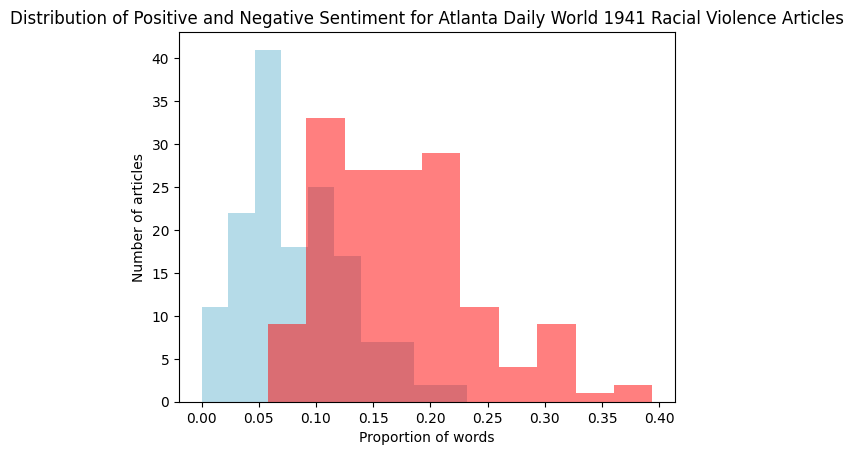

In [16]:
plt.hist(scores['Positive'], label='Positive', alpha=0.9, color='lightblue')
plt.hist(scores['Negative'], label='Negative', alpha=0.5, color='red')
plt.xlabel('Proportion of words')
plt.ylabel('Number of articles')
plt.title('Distribution of Positive and Negative Sentiment for Atlanta Daily World 1941 Racial Violence Articles')

In [17]:
articles_nonviolence = merged_articles[merged_articles['entry'] == 0]
non_violent_scores = score_sentiment(articles_nonviolence, 'text_x')

(array([ 19.,  75., 189., 165., 124., 100.,  45.,  36.,  15.,  10.]),
 array([0.006 , 0.0448, 0.0836, 0.1224, 0.1612, 0.2   , 0.2388, 0.2776,
        0.3164, 0.3552, 0.394 ]),
 <BarContainer object of 10 artists>)

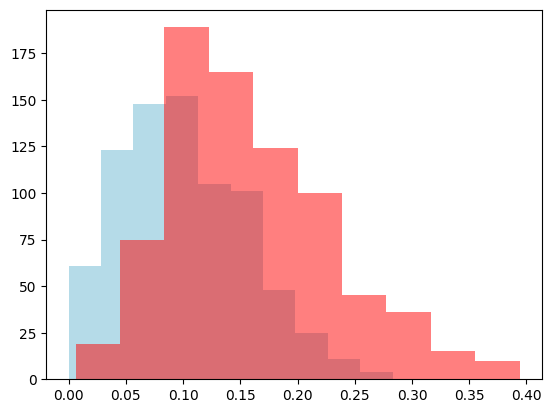

In [18]:
plt.hist(non_violent_scores['Positive'], label='Positive', alpha=0.9, color='lightblue')
plt.hist(non_violent_scores['Negative'], label='Negative', alpha=0.5, color='red')

(array([ 4.,  5., 17., 16., 15., 12., 16., 11., 16., 13.,  5.,  6.,  2.,
         2.,  6.,  3.,  0.,  1.,  1.,  1.]),
 array([0.058 , 0.0748, 0.0916, 0.1084, 0.1252, 0.142 , 0.1588, 0.1756,
        0.1924, 0.2092, 0.226 , 0.2428, 0.2596, 0.2764, 0.2932, 0.31  ,
        0.3268, 0.3436, 0.3604, 0.3772, 0.394 ]),
 <BarContainer object of 20 artists>)

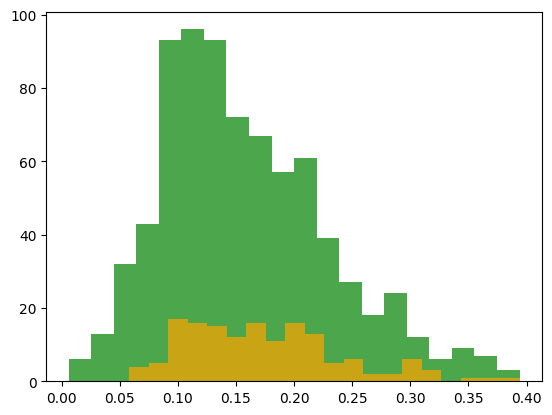

In [19]:
plt.hist(non_violent_scores['Negative'], label='Non-violent', alpha=0.7, color='green', bins=20)
plt.hist(scores['Negative'], label='Violent', alpha=0.7, color='orange', bins=20)

(array([ 5.,  6., 13.,  9., 24., 17., 10.,  8., 13., 12., 10.,  7.,  3.,
         4.,  5.,  2.,  1.,  1.,  1.,  1.]),
 array([0.    , 0.0116, 0.0232, 0.0348, 0.0464, 0.058 , 0.0696, 0.0812,
        0.0928, 0.1044, 0.116 , 0.1276, 0.1392, 0.1508, 0.1624, 0.174 ,
        0.1856, 0.1972, 0.2088, 0.2204, 0.232 ]),
 <BarContainer object of 20 artists>)

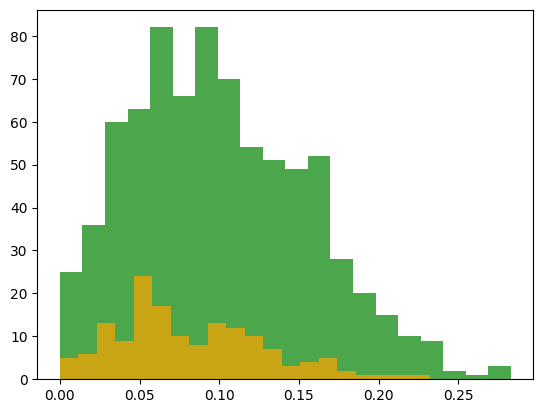

In [20]:
plt.hist(non_violent_scores['Positive'], label='Non-violent', alpha=0.7, color='green', bins=20)
plt.hist(scores['Positive'], label='Violent', alpha=0.7, color='orange', bins=20)

In [21]:
print(non_violent_scores['Negative'].mean())
print(scores['Negative'].mean())

0.15816709511568125
0.174625


T-test for negativity between 2 article groups

In [22]:
def t_test(df1, df2, sentiment_type):
    mu1 = df1[sentiment_type].mean()
    var1 = np.var(df1[sentiment_type])
    n1 = len(df1)

    mu2 = df2[sentiment_type].mean()
    var2 = np.var(df2[sentiment_type])
    n2 = len(df2)

    t_value = (mu1-mu2)/np.sqrt((var1/n1) + (var2/n2))

    return t_value

In [23]:
def degrees_of_freedom(df1, df2, sentiment_type):
    var1 = np.var(df1[sentiment_type])
    n1 = len(df1)

    var2 = np.var(df2[sentiment_type])
    n2 = len(df2)

    print(var1, n1)
    print(var2, n2)

    num = ((var1**2/n1) + (var2**2/n2))**2
    denom1 = ((var1**2/n1)**2/(n1-1))
    denom2 = ((var2**2/n2)**2/(n2-1))

    return num/(denom1 + denom2)

In [24]:
print(t_test(non_violent_scores, scores, 'Negative'))

-2.757382105892128


T-test reveals that the violence articles contain significantly more negative sentiment

In [25]:
print(degrees_of_freedom(non_violent_scores, scores, 'Negative'))

0.0052725453440038055 778
0.004384892269736843 152
244.5652764566976


In [26]:
print(non_violent_scores['Negative'].median())
print(scores['Negative'].median())

0.145
0.1655


In [27]:
print(non_violent_scores['Positive'].mean())
print(scores['Positive'].mean())

0.10072879177377893
0.08258552631578948


T-test for positive reveals that non-violence articles contain significantly more positive sentiment

In [28]:
print(t_test(non_violent_scores, scores, 'Positive'))

4.209270919781524


Neutral t-test: no significant difference

In [29]:
print(t_test(non_violent_scores, scores, 'Neutral'))

-0.2598285610628474


Compound t-test: much more positive for the non-violent overall

In [30]:
print(t_test(non_violent_scores, scores, 'Compound'))

5.935199927017676


In [31]:
print(non_violent_scores['Positive'].median())
print(scores['Positive'].median())

0.096
0.072


NYT v. Atlanta Daily World

In [32]:
nyt = pd.read_excel('/Users/clairefenton/Downloads/NYT_predictions.xlsx')

In [33]:
new_text = []
for i in range(len(nyt)):
    text = nyt['original_text'].iloc[i]
    text = text_preprocessing(text)
    new_text.append(text)
nyt['text'] = new_text

In [34]:
nyt_violent = nyt[nyt['Correct_KC'] == 1]
nyt_scores = score_sentiment(nyt_violent, 'text')
print(nyt_scores.Negative.mean())
print(scores.Negative.mean())
t_test(nyt_scores, scores, 'Negative')

0.1725723404255319
0.174625


-0.3421651410489064

In [35]:
print(nyt_scores.Positive.mean())
print(scores.Positive.mean())
t_test(nyt_scores, scores, 'Positive')

0.09306063829787234
0.08258552631578948


2.455093332598668

In [36]:
print(nyt_scores.Neutral.mean())
print(scores.Neutral.mean())
t_test(nyt_scores, scores, 'Neutral')

0.7343829787234042
0.7428157894736842


-1.2971223461173975

In [37]:
print(nyt_scores.Compound.mean())
print(scores.Compound.mean())
t_test(nyt_scores, scores, 'Compound')

-0.41969446808510635
-0.6921131578947368


4.845840476994295

What if we normalized by removing neutral sentiment? Significantly more neutral in ATL, likely because of all the fluff and extraneous articles getting tacked on to actual racial violence

In [38]:
atl_norm = pd.DataFrame()
atl_norm['Positive'] = scores.Positive / (scores.Positive + scores.Negative)
atl_norm['Negative'] = scores.Negative / (scores.Positive + scores.Negative)

nyt_norm = pd.DataFrame()
nyt_norm['Positive'] = nyt_scores.Positive / (nyt_scores.Positive + nyt_scores.Negative)
nyt_norm['Negative'] = nyt_scores.Negative / (nyt_scores.Positive + nyt_scores.Negative)

print(nyt_norm.Negative.mean())
print(atl_norm.Negative.mean())

t_test(nyt_norm, atl_norm, 'Negative')

0.640019037306897
0.6798140802240171


-2.7723073842965746

Looks like negative test is significant when neutral is removed (considering only 'emotional' text)

ATL Daily World 1970

In [39]:
atl70 = pd.read_excel('/Users/clairefenton/Downloads/ATL_1970_Predictions.xlsx')

In [40]:
new_text = []
for i in range(len(atl70)):
    text = atl70['original_text'].iloc[i]
    text = text_preprocessing(text)
    new_text.append(text)

0.17621743036837376 0.09142048517520215


Text(0.5, 1.0, 'Distribution of Positive and Negative Sentiment for Atlanta Daily World 1970 Racial Violence Articles')

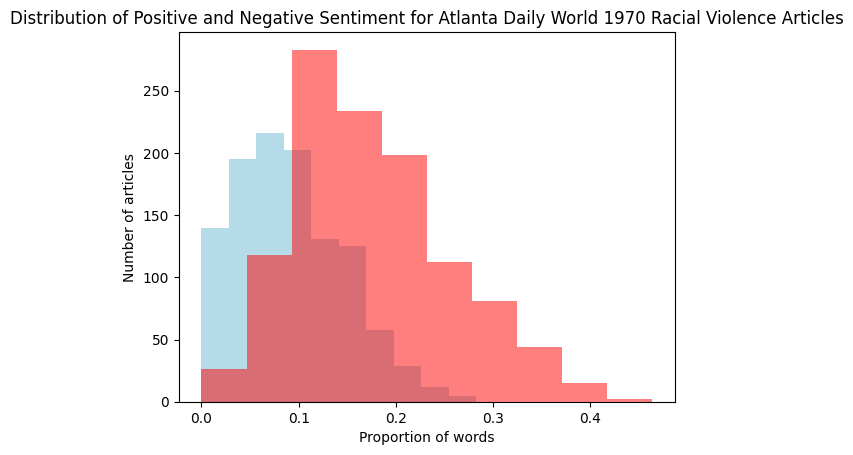

In [41]:
atl70['text'] = new_text
atl70_violent = atl70[atl70['CF_Correct'] == 1]
atl70_scores = score_sentiment(atl70_violent, 'text')
print(atl70_scores.Negative.mean(), atl70_scores.Positive.mean())
plt.hist(atl70_scores['Positive'], label='Positive', alpha=0.9, color='lightblue')
plt.hist(atl70_scores['Negative'], label='Negative', alpha=0.5, color='red')
plt.xlabel("Proportion of words")
plt.ylabel("Number of articles")
plt.title("Distribution of Positive and Negative Sentiment for Atlanta Daily World 1970 Racial Violence Articles")

In [42]:
atl70.to_excel('ATL_1970_Predictions_new_preprocessing.xlsx')

In [43]:
print(nyt_scores.Negative.mean())
print(atl70_scores.Negative.mean())

0.1725723404255319
0.17621743036837376


In [44]:
t_test(nyt_scores, atl70_scores, 'Negative')

-1.0089527293367704

In [45]:
t_test(nyt_scores, atl70_scores, 'Positive')

0.6492566458102638

In [46]:
t_test(nyt_scores, atl70_scores, 'Neutral')

0.5880039404493291

In [47]:
atl70_norm = pd.DataFrame()
atl70_norm['Positive'] = atl70_scores.Positive / (atl70_scores.Positive + atl70_scores.Negative)
atl70_norm['Negative'] = atl70_scores.Negative / (atl70_scores.Positive + atl70_scores.Negative)
print(t_test(nyt_norm, atl70_norm, 'Negative'))

-1.0145800187379002


In [48]:
print(t_test(scores, atl70_scores, 'Negative'))
print(t_test(scores, atl70_scores, 'Positive'))
print(t_test(atl_norm, atl70_norm, 'Negative'))

-0.2700994380129049
-2.109515718034778
2.1736425508518384


ATL Daily World 1940

In [49]:
atl40 = pd.read_excel('/Users/clairefenton/Downloads/ATL_1940-11-7.xlsx')

In [50]:
atl40 = atl40.dropna()
new_text = []
for i in range(len(atl40)):
    text = atl40['original_text'].iloc[i]
    text = text_preprocessing(text)
    new_text.append(text)
atl40['text'] = new_text

0.17381357196122296 0.08908277404921701


Text(0.5, 1.0, 'Distribution of Positive and Negative Sentiment for Atlanta Daily World 1940 Racial Violence Articles')

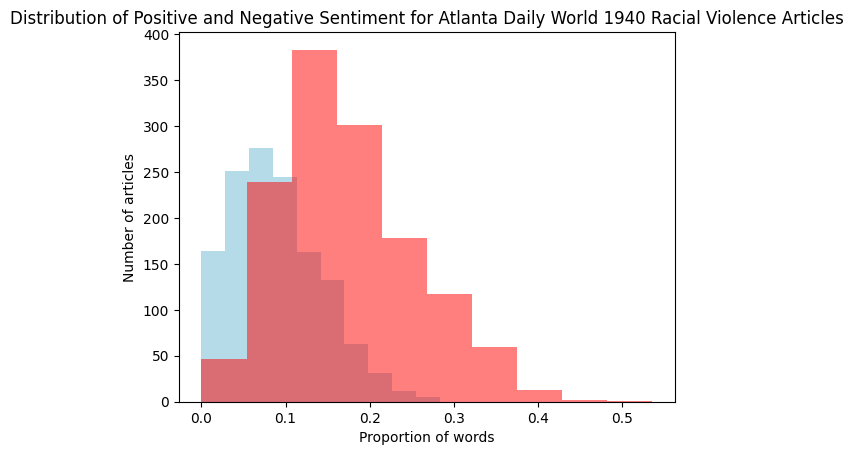

In [51]:
atl40_violent = atl40[atl40['entry'] == 1]
atl40_scores = score_sentiment(atl40_violent, 'text')
print(atl40_scores.Negative.mean(), atl40_scores.Positive.mean())

atl40_norm = pd.DataFrame()
atl40_norm['Positive'] = atl40_scores.Positive / (atl40_scores.Positive + atl40_scores.Negative)
atl40_norm['Negative'] = atl40_scores.Negative / (atl40_scores.Positive + atl40_scores.Negative)

plt.hist(atl40_scores['Positive'], label='Positive', alpha=0.9, color='lightblue')
plt.hist(atl40_scores['Negative'], label='Negative', alpha=0.5, color='red')
plt.xlabel("Proportion of words")
plt.ylabel("Number of articles")
plt.title("Distribution of Positive and Negative Sentiment for Atlanta Daily World 1940 Racial Violence Articles")

In [52]:
print(t_test(atl40_scores, scores, 'Negative'))
print(t_test(atl40_scores, scores, 'Positive'))
print(t_test(atl40_norm, atl_norm, 'Negative'))

-0.13985042620739646
1.580496314819641
-2.068637954754259


In [53]:
print(t_test(atl40_scores, atl70_scores, 'Negative'))
print(t_test(atl40_scores, atl70_scores, 'Positive'))
print(t_test(atl40_norm, atl70_norm, 'Negative'))

-0.7339188790081247
-1.0375481588849425
0.2511682894830444


In [54]:
print(t_test(atl40_scores, nyt_scores, 'Negative'))
print(t_test(atl40_scores, nyt_scores, 'Positive'))
print(t_test(atl40_norm, nyt_norm, 'Negative'))

0.3589571004698449
-1.6602483384508628
1.301492650716073


In [55]:
atl40.to_excel('ATL_1940_new_preprocessing.xlsx')